In [1]:
from lib.utils import compact_to_expanded, format_plot, imputation, update_figure_layout, decomposition_plot
from lib.utils import two_line_plot_secondary_axis, plot_autocorrelation
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import missingno as msno
from sklearn.metrics import mean_absolute_error
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

/home/hien/Work/AI/london_smart_meters/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ../..
project_folder = Path("AI/london_smart_meters")
source_data = project_folder/"data"
preprocessed_data = project_folder/"output"/"preprocessed_data"
dst_img = project_folder/"output"/"img"
dst_result = project_folder/"output"/"result"

/home/hien/Work


In [3]:
block_df = pd.read_parquet(preprocessed_data/"london_smart_meters_merged_block_0-7.parquet")
display(block_df.head())

LCLid start_timestamp frequency  \
0  MAC000002      2012-10-13     30min   
1  MAC000246      2012-01-01     30min   
2  MAC000450      2012-03-23     30min   
3  MAC001074      2012-05-09     30min   
4  MAC003223      2012-09-18     30min   

                                  energy_consumption  series_length stdorToU  \
0  [0.263, 0.2689999999999999, 0.275, 0.256, 0.21...          24144      Std   
1  [0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...          37872      Std   
2  [1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...          33936      Std   
3  [0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...          31680      ToU   
4  [0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...          25344      Std   

     Acorn Acorn_grouped     file  \
0  ACORN-A      Affluent  block_0   
1  ACORN-A      Affluent  block_0   
2  ACORN-A      Affluent  block_0   
3   ACORN-        ACORN-  block_0   
4  ACORN-A      Affluent  block_0   

                                            holidays  ...  \
0  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
1  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
2  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
3  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
4  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   

                                         windBearing  \
0  [186, 186, 188, 188, 190, 190, 203, 203, 206, ...   
1  [229, 229, 238, 238, 229, 229, 231, 231, 227, ...   
2  [78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...   
3  [215, 215, 207, 207, 215, 215, 216, 216, 126, ...   
4  [236, 236, 240, 240, 242, 242, 244, 244, 248, ...   

                                         temperature  \
0  [8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...   
1  [12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....   
2  [8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...   
3  [11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....   
4  [14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....   

                                            dewPoint  \
0  [6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...   
1  [10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....   
2  [7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...   
3  [10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....   
4  [10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...   

                                            pressure  \
0  [1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...   
1  [1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...   
2  [1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...   
3  [1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...   
4  [1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...   

                                 apparentTemperature  \
0  [7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...   
1  [12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....   
2  [7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...   
3  [11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....   
4  [14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....   

                                           windSpeed  \
0  [2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...   
1  [5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...   
2  [2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...   
3  [2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...   
4  [3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...   

                                          precipType  \
0  [rain, rain, rain, rain, rain, rain, rain, rai...   
1  [rain, rain, rain, rain, rain, rain, rain, rai...   
2  [rain, rain, rain, rain, rain, rain, rain, rai...   
3  [rain, rain, rain, rain, rain, rain, rain, rai...   
4  [rain, rain, rain, rain, rain, rain, rain, rai...   

                                                icon  \
0  [clear-night, clear-night, clear-night, clear-...   
1  [partly-cloudy-night, partly-cloudy-night, clo...   
2  [fog, fog, fog, fog, fog, fog, fog, fog, fog, ...   
3  [partly-cloudy-night, partly-cloudy-night, par...   
4  [clear-night, clear-night, clear-night, c

In [4]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

100%|██████████| 50/50 [00:00<00:00, 341.24it/s]


timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000050               0.175     30min          37872   
1 2012-01-01 00:30:00  MAC000050               0.212     30min          37872   
2 2012-01-01 01:00:00  MAC000050               0.313     30min          37872   
3 2012-01-01 01:30:00  MAC000050               0.302     30min          37872   
4 2012-01-01 02:00:00  MAC000050               0.257     30min          37872   

  stdorToU    Acorn Acorn_grouped     file    holidays  ...  windBearing  \
0      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
1      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
2      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
3      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
4      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   

   temperature  dewPoint  pressure  apparentTemperature  windSpeed  \
0        12.12     10.97   1008.10                12.12       5.90   
1        12.12     10.97   1008.10                12.12       5.90   
2        12.59     11.02   1007.88                12.59       6.06   
3        12.59     11.02   1007.88                12.59       6.06   
4        12.45     11.04   1007.95                12.45       5.31   

   precipType                 icon humidity        summary  
0        rain  partly-cloudy-night     0.93  Mostly Cloudy  
1        rain  partly-cloudy-night     0.93  Mostly Cloudy  
2        rain               cloudy     0.90       Overcast  
3        rain               cloudy     0.90       Overcast  
4        rain  partly-cloudy-night     0.91  Mostly Cloudy  

[5 rows x 21 columns]

# Missing Values Imputation

/home/hien/Work/AI/london_smart_meters/.venv/lib/python3.12/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/home/hien/Work/AI/london_smart_meters/.venv/lib/python3.12/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


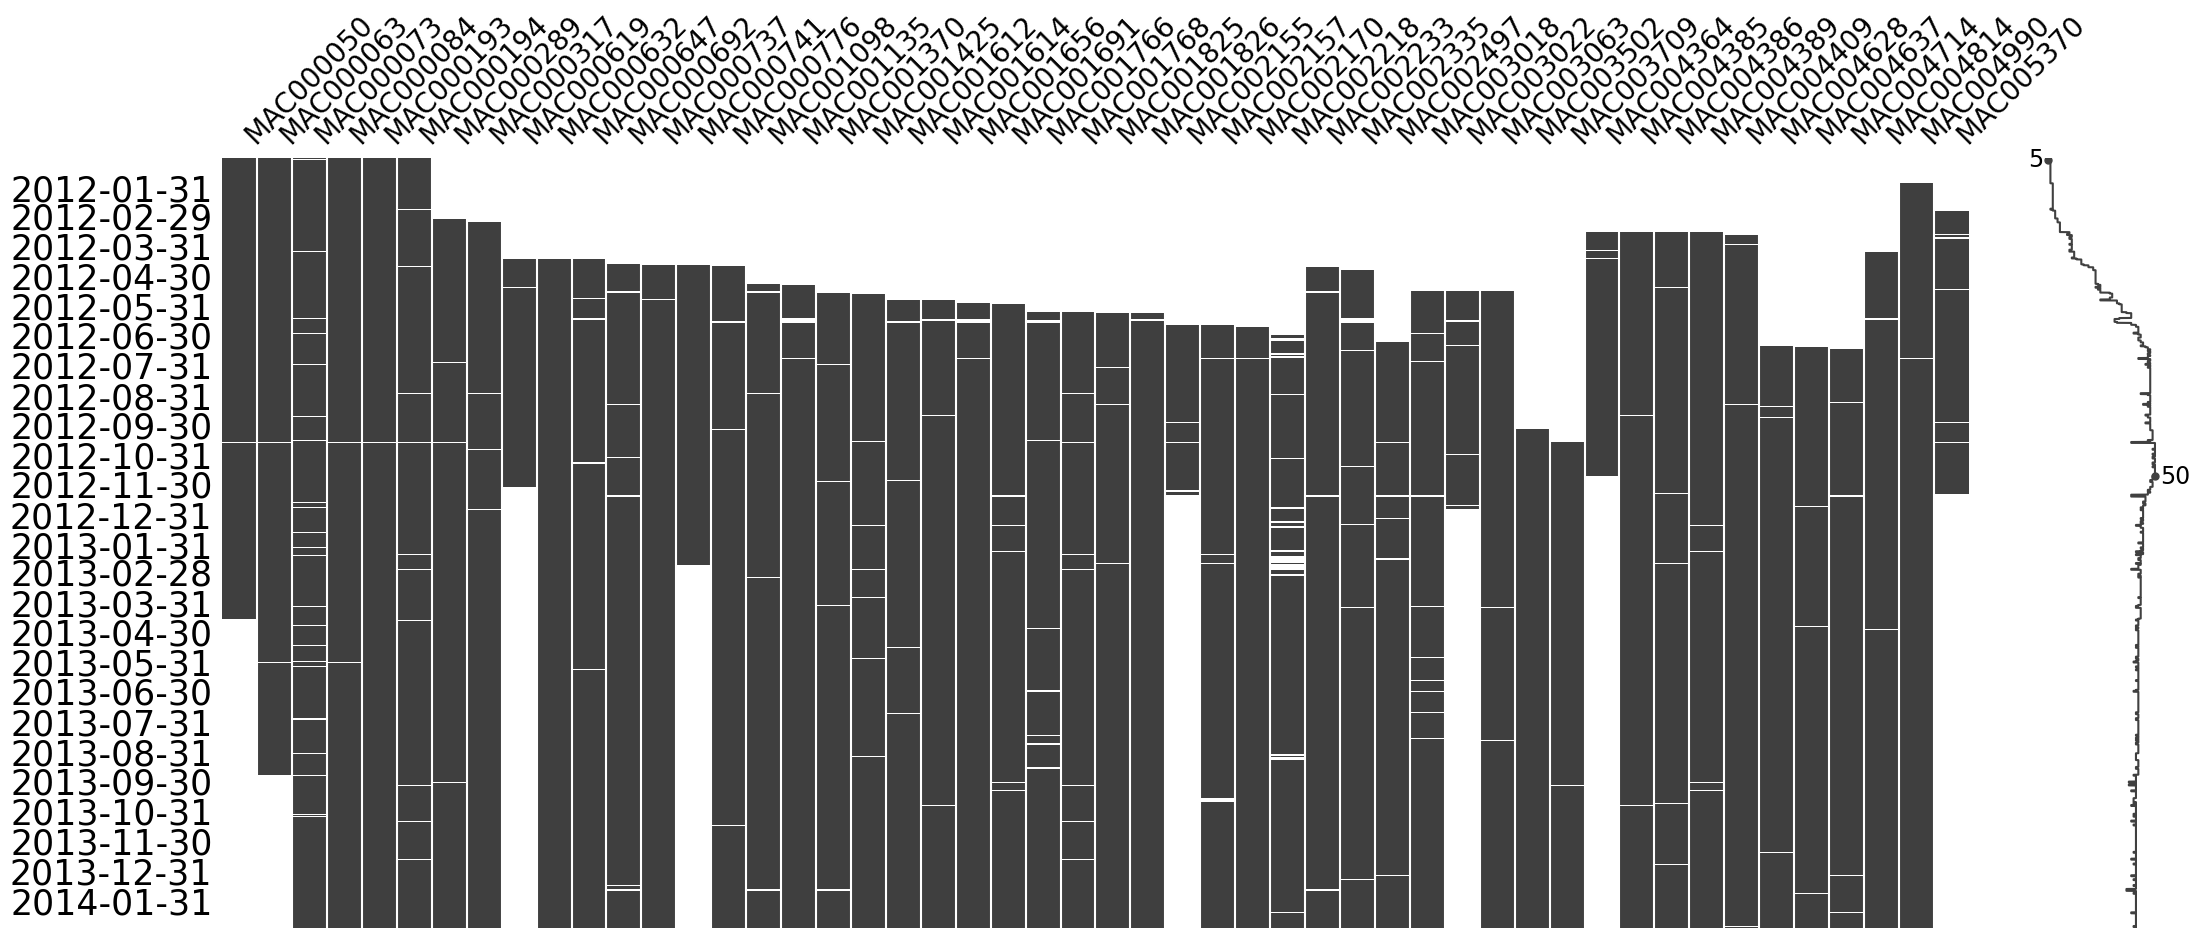

In [5]:
# Pivot the data to set the index as the datetime and the different time series along the columns
plot_df = pd.pivot_table(exp_block_df, index="timestamp", columns="LCLid", values="energy_consumption")
# Generate Plot. Since we have a datetime index, we can mention the frequency to decide what do we want on the X axis
msno.matrix(plot_df, freq="M", fontsize=20)
plt.savefig(dst_img/'missing_no_full.png', bbox_inches='tight')
plt.show()

In [6]:
# Taking a single time series from the block
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

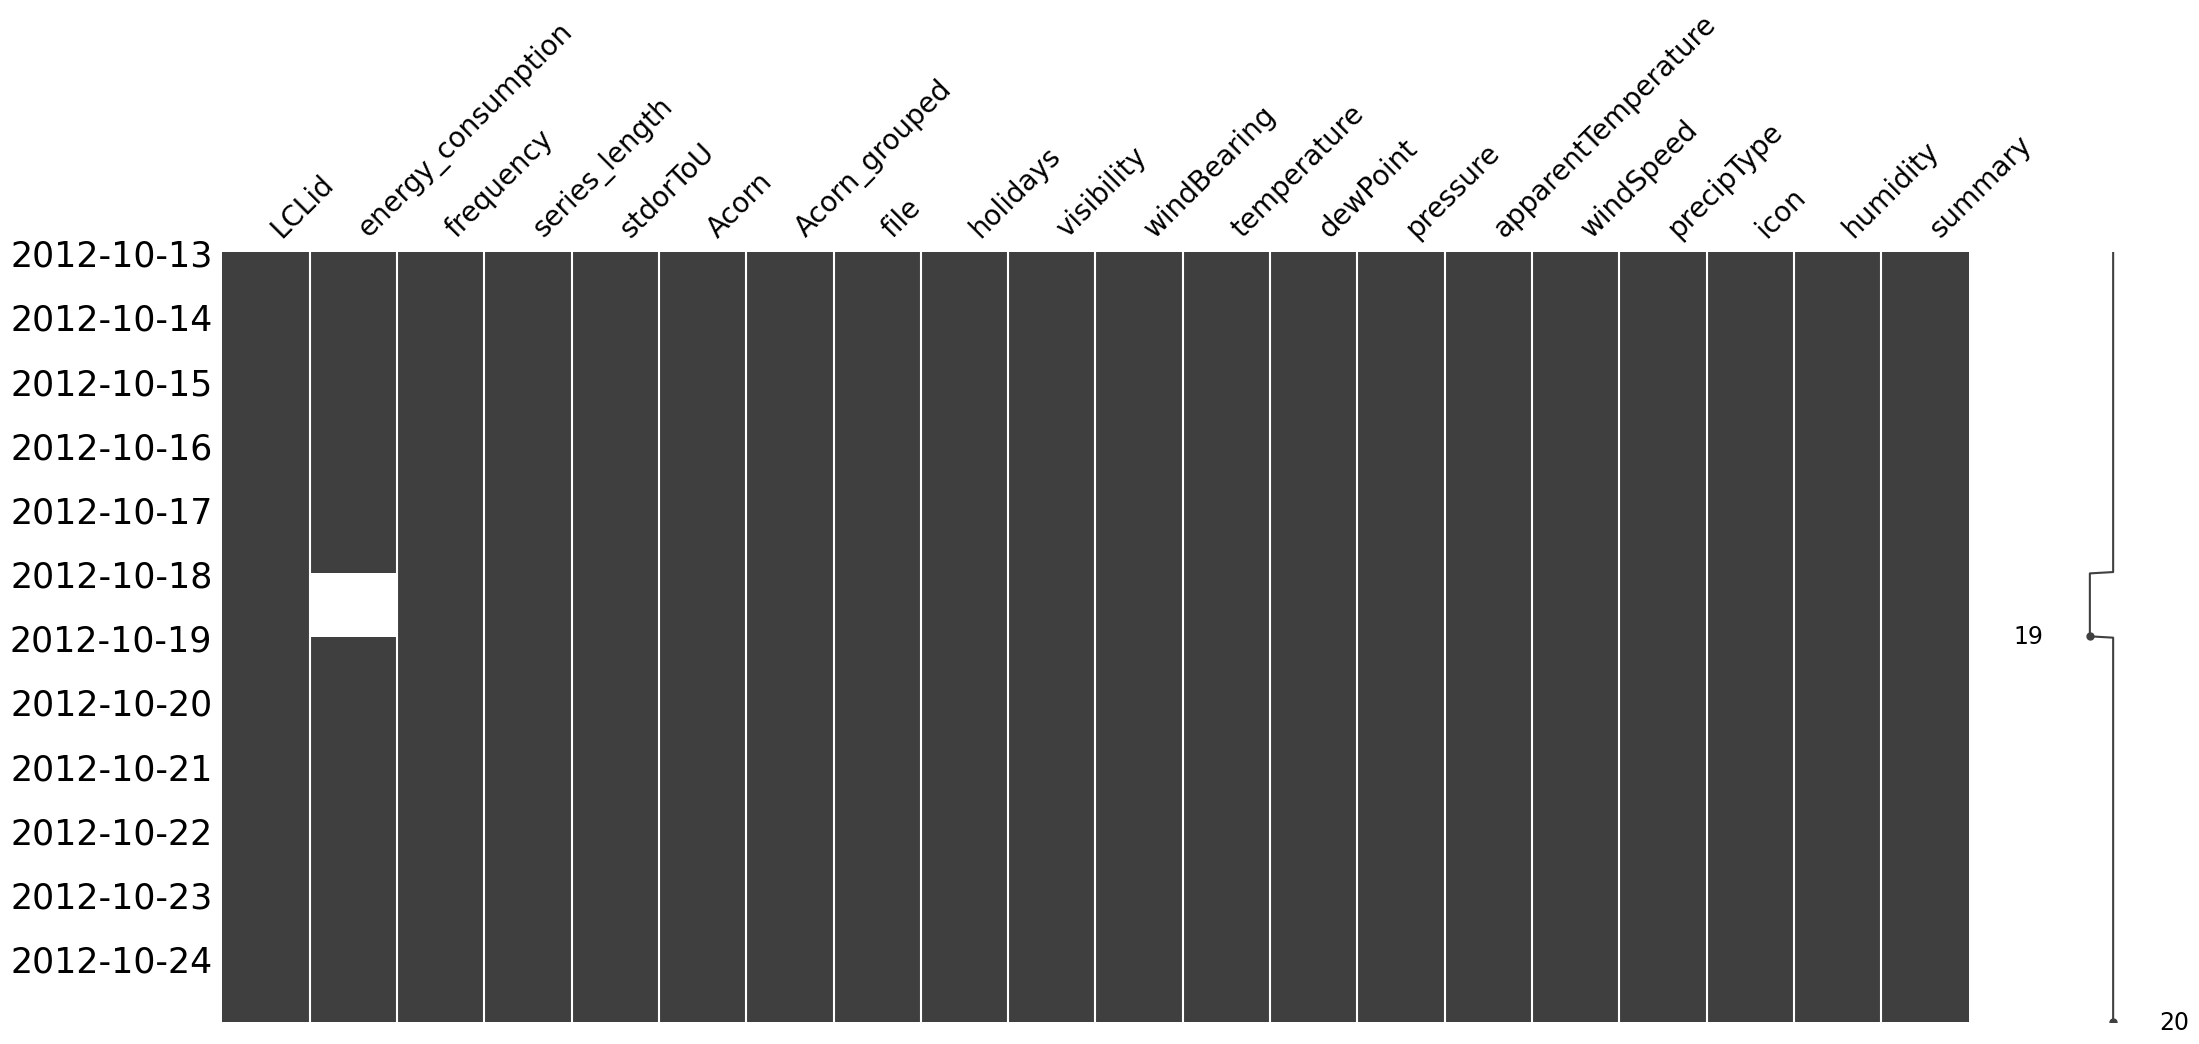

In [7]:
msno.matrix(ts_df["2012-10-13": "2012-10-24"], freq="D", fontsize=20)
plt.savefig(dst_img/'missing_no_mac000193.png', bbox_inches='tight')
plt.show()

In [8]:
ts_df2 = ts_df.copy()
ts_df2

LCLid  energy_consumption frequency  series_length  \
timestamp                                                                     
2012-01-01 00:00:00  MAC000193               0.368     30min          37872   
2012-01-01 00:30:00  MAC000193               0.386     30min          37872   
2012-01-01 01:00:00  MAC000193               0.170     30min          37872   
2012-01-01 01:30:00  MAC000193               0.021     30min          37872   
2012-01-01 02:00:00  MAC000193               0.038     30min          37872   
...                        ...                 ...       ...            ...   
2014-02-27 21:30:00  MAC000193               0.217     30min          37872   
2014-02-27 22:00:00  MAC000193               0.169     30min          37872   
2014-02-27 22:30:00  MAC000193               0.268     30min          37872   
2014-02-27 23:00:00  MAC000193               0.253     30min          37872   
2014-02-27 23:30:00  MAC000193               0.280     30min          37872   

                    stdorToU    Acorn Acorn_grouped     file    holidays  \
timestamp                                                                  
2012-01-01 00:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 00:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 01:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 01:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 02:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
...                      ...      ...           ...      ...         ...   
2014-02-27 21:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 22:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 22:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 23:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 23:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   

                     visibility  windBearing  temperature  dewPoint  pressure  \
timestamp                                                                       
2012-01-01 00:00:00       12.99          229        12.12     10.97   1008.10   
2012-01-01 00:30:00       12.99          229        12.12     10.97   1008.10   
2012-01-01 01:00:00       12.89          238        12.59     11.02   1007.88   
2012-01-01 01:30:00       12.89          238        12.59     11.02   1007.88   
2012-01-01 02:00:00       11.54          229        12.45     11.04   1007.95   
...                         ...          ...          ...       ...       ...   
2014-02-27 21:30:00       16.09          217         5.03      1.67   1006.36   
2014-02-27 22:00:00       14.00          216         4.10      1.64   1005.67   
2014-02-27 22:30:00       14.00          216         4.10      1.64   1005.67   
2014-02-27 23:00:00       14.03          200         3.93      1.61   1004.62   
2014-02-27 23:30:00       14.03          200         3.93      1.61   1004.62   

                     apparentTemperature  windSpeed precipType  \
timestamp                                                        
2012-01-01 00:00:00                12.12       5.90       rain   
2012-01-01 00:30:00                12.12       5.90       rain   
2012-01-01 01:00:00                12.59       6.06       rain   
2012-01-01 01:30:00                12.59       6.06       rain   
2012-01-01 02:00:00                12.45       5.31       rain   
...                                  ...        ...        ...   
2014-02-27 21:30:00                 2.50       3.06       rain   
2014-02-27 22:00:00                 1.41       3.02       rain   
2014-02-27 22:30:00                 1.41       3.02       rain   
2014-02-27 23:00:00                 1.42       2.75       rain   
2014-02-27 23:30:00                 1.42       2.75       rain   

                                    icon  humidity        summary  
timestamp                  

## Imputation techniques comparison

In [9]:
# The dates between which we are nulling out the time series
window = slice("2012-10-07", "2012-10-08")
# Creating a new column and artificially creating missing values
ts_df2['energy_consumption_missing'] = ts_df2.energy_consumption
ts_df2.loc[window, "energy_consumption_missing"] = np.nan
# Creating a new window with a few dates added on either side for visualization purposes
vis_window = slice(pd.to_datetime(window.start) - pd.Timedelta(days=2), pd.to_datetime(window.stop) + pd.Timedelta(days=2))

In [10]:
fig = px.line(ts_df2[vis_window], y="energy_consumption_missing", title=f"MAC000193 Energy Consumption between {vis_window.start.strftime('%Y-%m-%d')} and {vis_window.stop.strftime('%Y-%m-%d')}")
fig = format_plot(fig)
fig.write_image(dst_img/"mac000193_missing.png")
fig.show()

In [11]:
#Create a column with the Hour from timestamp
ts_df2["hour"] = ts_df2.index.hour
#Calculate hourly average consumption
hourly_profile = ts_df2.groupby(['hour'])['energy_consumption'].mean().reset_index()
hourly_profile.rename(columns={"energy_consumption": "hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df2.index
#Merge the hourly profile dataframe to ts dataframe
ts_df2 = ts_df2.merge(hourly_profile, on=['hour'], how='left', validate="many_to_one")
ts_df2.index = idx

### Hourly profile imputation

In [12]:
#Using the hourly profile to fill missing
ts_df2['hourly_profile_imputed'] = ts_df2['energy_consumption_missing']
ts_df2['hourly_profile_imputed'] = ts_df2['energy_consumption_missing'].fillna(ts_df2['hourly_profile'])
mae = mean_absolute_error(ts_df2.loc[window, "hourly_profile_imputed"], ts_df2.loc[window, "energy_consumption"])

In [13]:
plot_df = pd.melt(ts_df2.loc[window,['energy_consumption','hourly_profile_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Hourly Profile | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Hourly Profile Imputed'])
fig.write_image(dst_img/"hourly_profile_imputation.png")
fig

### Weekday-hourly profile imputation

In [14]:
#Create a column with the weekday from timestamp
ts_df2["weekday"] = ts_df2.index.weekday
#Calculate weekday-hourly average consumption
day_hourly_profile = ts_df2.groupby(['weekday','hour'])['energy_consumption'].mean().reset_index()
day_hourly_profile.rename(columns={"energy_consumption": "day_hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df2.index
#Merge the day-hourly profile dataframe to ts dataframe
ts_df2 = ts_df2.merge(day_hourly_profile, on=['weekday', 'hour'], how='left', validate="many_to_one")
ts_df2.index = idx

In [15]:
#Using the day-hourly profile to fill missing
ts_df2['day_hourly_profile_imputed'] = ts_df2['energy_consumption_missing']
ts_df2['day_hourly_profile_imputed'] = ts_df2['energy_consumption_missing'].fillna(ts_df2['day_hourly_profile'])
mae = mean_absolute_error(ts_df2.loc[window, "day_hourly_profile_imputed"], ts_df2.loc[window, "energy_consumption"])

In [16]:
plot_df = pd.melt(ts_df2.loc[window,['energy_consumption','day_hourly_profile_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Week Day-Hourly Profile | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Week Day-Hourly Profile Imputed'])
fig.write_image(dst_img/"day_hourly_profile_imputation.png")
fig


# Visualization

In [17]:
ts_df3 = ts_df.copy()

In [18]:
ts_df3["weekday_name"] = ts_df3.index.day_name()
ts_df3["weekday"] = ts_df3.index.weekday
ts_df3["week"] = ts_df3.index.isocalendar().week
ts_df3["day"] = ts_df3.index.day
ts_df3["hour"] = ts_df3.index.hour
ts_df3["date"] = ts_df3.index.date
ts_df3["month"] = ts_df3.index.month
ts_df3["month_name"] = ts_df3.index.month_name()
ts_df3["year"] = ts_df3.index.year

In [19]:
#Making ordered categoricals to make for sorted plots
ts_df3['month_name'] = pd.Categorical(ts_df3['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df3['weekday_name'] = pd.Categorical(ts_df3['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [20]:
ts_df3

LCLid  energy_consumption frequency  series_length  \
timestamp                                                                     
2012-01-01 00:00:00  MAC000193               0.368     30min          37872   
2012-01-01 00:30:00  MAC000193               0.386     30min          37872   
2012-01-01 01:00:00  MAC000193               0.170     30min          37872   
2012-01-01 01:30:00  MAC000193               0.021     30min          37872   
2012-01-01 02:00:00  MAC000193               0.038     30min          37872   
...                        ...                 ...       ...            ...   
2014-02-27 21:30:00  MAC000193               0.217     30min          37872   
2014-02-27 22:00:00  MAC000193               0.169     30min          37872   
2014-02-27 22:30:00  MAC000193               0.268     30min          37872   
2014-02-27 23:00:00  MAC000193               0.253     30min          37872   
2014-02-27 23:30:00  MAC000193               0.280     30min          37872   

                    stdorToU    Acorn Acorn_grouped     file    holidays  \
timestamp                                                                  
2012-01-01 00:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 00:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 01:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 01:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 02:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
...                      ...      ...           ...      ...         ...   
2014-02-27 21:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 22:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 22:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 23:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 23:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   

                     visibility  ...        summary  weekday_name  weekday  \
timestamp                        ...                                         
2012-01-01 00:00:00       12.99  ...  Mostly Cloudy        Sunday        6   
2012-01-01 00:30:00       12.99  ...  Mostly Cloudy        Sunday        6   
2012-01-01 01:00:00       12.89  ...       Overcast        Sunday        6   
2012-01-01 01:30:00       12.89  ...       Overcast        Sunday        6   
2012-01-01 02:00:00       11.54  ...  Mostly Cloudy        Sunday        6   
...                         ...  ...            ...           ...      ...   
2014-02-27 21:30:00       16.09  ...          Clear      Thursday        3   
2014-02-27 22:00:00       14.00  ...          Clear      Thursday        3   
2014-02-27 22:30:00       14.00  ...          Clear      Thursday        3   
2014-02-27 23:00:00       14.03  ...          Clear      Thursday        3   
2014-02-27 23:30:00       14.03  ...          Clear      Thursday        3   

                     week  day  hour        date month  month_name  year  
timestamp                                                                 
2012-01-01 00:00:00    52    1     0  2012-01-01     1     January  2012  
2012-01-01 00:30:00    52    1     0  2012-01-01     1     January  2012  
2012-01-01 01:00:00    52    1     1  2012-01-01     1     January  2012  
2012-01-01 01:30:00    52    1     1  2012-01-01     1     January  2012  
2012-01-01 02:00:00    52    1     2  2012-01-01     1     January  2012  
...                   ...  ...   ...         ...   ...         ...   ...  
2014-02-27 21:30:00     9   27    21  2014-02-27     2    February  2014  
2014-02-27 22:00:00     9   27    22  2014-02-27     2    February  2014  
2014-02-27 22:30:00     9   27    22  2014-02-27     2    February  2014  
2014-02-27 23:00:00     9   27    23  2014-02-27     2    February  2014  
2014-02-27 23:30:00     9   27    23  2014-02-27     2    February  2014  

[37872 rows x 29 

In [21]:
ts_df3 = imputation(ts_df3)
ts_df3

LCLid  energy_consumption frequency  series_length  \
timestamp                                                                     
2012-01-01 00:00:00  MAC000193               0.368     30min          37872   
2012-01-01 00:30:00  MAC000193               0.386     30min          37872   
2012-01-01 01:00:00  MAC000193               0.170     30min          37872   
2012-01-01 01:30:00  MAC000193               0.021     30min          37872   
2012-01-01 02:00:00  MAC000193               0.038     30min          37872   
...                        ...                 ...       ...            ...   
2014-02-27 21:30:00  MAC000193               0.217     30min          37872   
2014-02-27 22:00:00  MAC000193               0.169     30min          37872   
2014-02-27 22:30:00  MAC000193               0.268     30min          37872   
2014-02-27 23:00:00  MAC000193               0.253     30min          37872   
2014-02-27 23:30:00  MAC000193               0.280     30min          37872   

                    stdorToU    Acorn Acorn_grouped     file    holidays  \
timestamp                                                                  
2012-01-01 00:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 00:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 01:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 01:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2012-01-01 02:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
...                      ...      ...           ...      ...         ...   
2014-02-27 21:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 22:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 22:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 23:00:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   
2014-02-27 23:30:00      ToU  ACORN-D      Affluent  block_7  NO_HOLIDAY   

                     visibility  ...  weekday  week  day  hour        date  \
timestamp                        ...                                         
2012-01-01 00:00:00       12.99  ...        6    52    1     0  2012-01-01   
2012-01-01 00:30:00       12.99  ...        6    52    1     0  2012-01-01   
2012-01-01 01:00:00       12.89  ...        6    52    1     1  2012-01-01   
2012-01-01 01:30:00       12.89  ...        6    52    1     1  2012-01-01   
2012-01-01 02:00:00       11.54  ...        6    52    1     2  2012-01-01   
...                         ...  ...      ...   ...  ...   ...         ...   
2014-02-27 21:30:00       16.09  ...        3     9   27    21  2014-02-27   
2014-02-27 22:00:00       14.00  ...        3     9   27    22  2014-02-27   
2014-02-27 22:30:00       14.00  ...        3     9   27    22  2014-02-27   
2014-02-27 23:00:00       14.03  ...        3     9   27    23  2014-02-27   
2014-02-27 23:30:00       14.03  ...        3     9   27    23  2014-02-27   

                     month month_name  year  day_hourly_profile  \
timestamp                                                         
2012-01-01 00:00:00      1    January  2012            0.094973   
2012-01-01 00:30:00      1    January  2012            0.094973   
2012-01-01 01:00:00      1    January  2012            0.033252   
2012-01-01 01:30:00      1    January  2012            0.033252   
2012-01-01 02:00:00      1    January  2012            0.033372   
...                    ...        ...   ...                 ...   
2014-02-27 21:30:00      2   February  2014            0.278585   
2014-02-27 22:00:00      2   February  2014            0.263335   
2014-02-27 22:30:00      2   February  2014            0.263335   
2014-02-27 23:00:00      2   February  2014            0.202089   
2014-02-27 23:30:00      2   February  2014            0.202089   

                    energy_consumption_imputed  
timestamp                                       
2012-01-01 00:00:00    

In [22]:
ts_df3["rolling_monthly_avg"] = ts_df3["energy_consumption_imputed"].rolling(window=48*30).mean()

fig = px.line(ts_df3, y="rolling_monthly_avg", title="Rolling Monthly Average Energy Consumption for MAC000193")
fig = format_plot(fig, ylabel="Energy Consumption")
fig.write_image(dst_img/"rolling_avg_line_plot.png")
fig.show()

In [23]:
fig = two_line_plot_secondary_axis(x=ts_df3.index,
                                   y1=ts_df3.energy_consumption_imputed,
                                   y2=ts_df3.temperature,
                                   y1_name="Energy Consumption",
                                   y2_name="Temperature",
                                   title="Temperature and Energy Consumption",
                                   # greyscale=True,
                                  dash_secondary=False)
update_figure_layout(fig, font_size=15)
fig.write_image(dst_img/"temp_vs_energy.png")
fig.show()

In [24]:
zoom_window = slice("2012-03-16", "2012-03-18")
fig = two_line_plot_secondary_axis(x=ts_df3[zoom_window].index,
                                   y1=ts_df3[zoom_window].energy_consumption_imputed,
                                   y2=ts_df3[zoom_window].temperature,
                                   y1_name="Energy Consumption",
                                   y2_name="Temperature",
                                   title="Temperature and Energy Consumption (2012-03-16 to 2012-03-30)",
                                   greyscale=False,
                                   dash_secondary=True)
update_figure_layout(fig, font_size=15)
fig.write_image(dst_img/"temp_vs_energy_zoomed.png")
fig.show()


In [25]:
#Montlhly Average energy consumption
plot_df = ts_df3[~ts_df3.year.isin([2011, 2014])].groupby(["year", "month_name"])[['energy_consumption_imputed',"temperature"]].mean().reset_index()

/tmp/ipykernel_1020476/2962810846.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [26]:
fig = px.line(plot_df, x="month_name", y='energy_consumption_imputed', color="year", line_dash="year", title="Seasonal Plot - Monthly")
fig = format_plot(fig, ylabel="Energy Consumption", xlabel="Month")
update_figure_layout(fig, font_size=15)
fig.write_image(dst_img/"seasonal_plot_monthly.png")
fig.show()

In [27]:
zoom_year_2012 = slice("2012-01-01", "2012-12-01")
# Only resample numeric columns
numeric_cols = ts_df3[zoom_year_2012].select_dtypes(exclude=['category']).columns
monthly_data_2012 = ts_df3[zoom_year_2012][numeric_cols].resample('ME').mean(numeric_only=True)
fig = two_line_plot_secondary_axis(x=monthly_data_2012.index,
                                   y1=monthly_data_2012.energy_consumption_imputed,
                                   y2=monthly_data_2012.temperature,
                                   y1_name="Energy Consumption",
                                   y2_name="Temperature",
                                   title="Monthly Average Temperature and Energy Consumption (2012)",
                                   greyscale=False,
                                   dash_secondary=True)
update_figure_layout(fig, font_size=15)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %Y",
    ticklabelmode="period"
)
fig.write_image(dst_img/"temp_vs_energy_zoomed_2012.png")
fig.show()

In [28]:
zoom_year_2013 = slice("2013-01-01", "2013-12-01")
# Only resample numeric columns
numeric_cols = ts_df3[zoom_year_2013].select_dtypes(exclude=['category']).columns
monthly_data_2013 = ts_df3[zoom_year_2013][numeric_cols].resample('ME').mean(numeric_only=True)
fig = two_line_plot_secondary_axis(x=monthly_data_2013.index,
                                   y1=monthly_data_2013.energy_consumption_imputed,
                                   y2=monthly_data_2013.temperature,
                                   y1_name="Energy Consumption",
                                   y2_name="Temperature",
                                   title="Monthly Average Temperature and Energy Consumption (2013)",
                                   greyscale=False,
                                   dash_secondary=True)
update_figure_layout(fig, font_size=15)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %Y",
    ticklabelmode="period"
)
fig.write_image(dst_img/"temp_vs_energy_zoomed_2013.png")
fig.show()

In [29]:
plot_df = ts_df3.groupby(["date","weekday_name", "hour"])["energy_consumption"].mean().reset_index().dropna()

/tmp/ipykernel_1020476/4188232335.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [30]:
fig = px.box(plot_df, y="energy_consumption", x="hour", log_y=True, title="Box Plot: Day of Month-Hourly Average")
fig = format_plot(fig, ylabel="Energy Consumption", xlabel="Hours", legends=None)
fig.write_image(dst_img/"box_plot_hourly_avg.png")
fig.show()


In [31]:
plot_df = pd.pivot_table(ts_df3, index="weekday_name", values='energy_consumption', columns="hour", aggfunc="mean")

/tmp/ipykernel_1020476/1586138872.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [32]:
fig = px.imshow(plot_df, height=600, title="Energy Consumption: Hours vs Week Day")
fig = format_plot(fig, ylabel="Week Day", xlabel="Hours", legends=None)
fig.write_image(dst_img/"hour_weekday_heatmap.png")
fig.show()

In [33]:
#Does not support misssing values, so using imputed ts instead
res = seasonal_decompose(ts_df3['energy_consumption_imputed'], period=7*48, model="additive", extrapolate_trend="freq", filt=np.repeat(1/(30*48), 30*48))

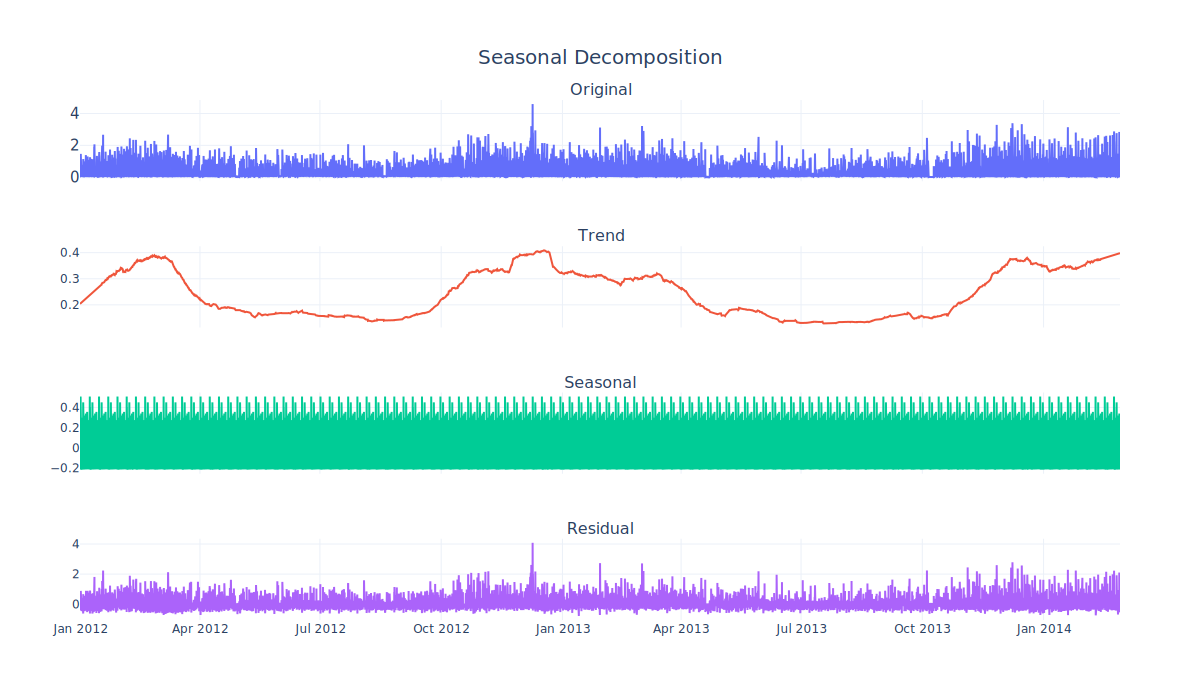

In [34]:
fig = decomposition_plot(ts_df3.index, res.observed, res.seasonal, res.trend, res.resid)
fig.write_image(dst_img/"moving_avg_decomposition.png")
fig.show(renderer="svg")

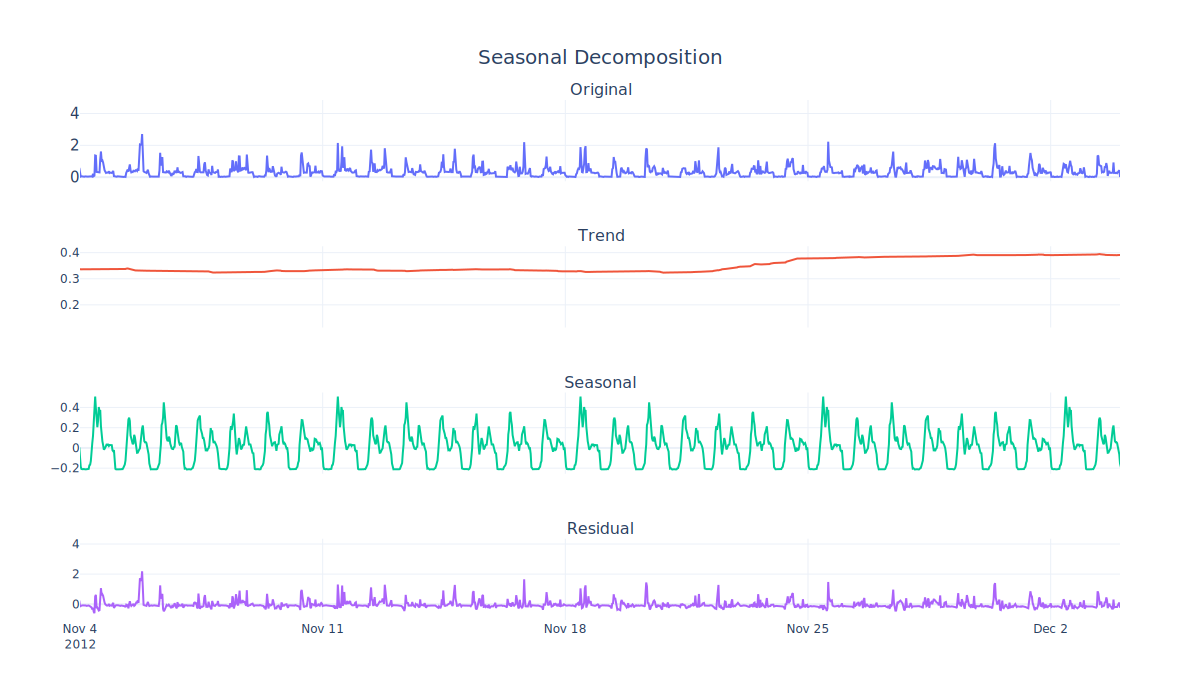

In [35]:
#Let's zoom in on a few days to better see the seasonality extracted
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image(dst_img/"moving_avg_decomposition_zoomed.png")
fig.show(renderer="svg")


In [36]:
exp_block_df.head()

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000050               0.175     30min          37872   
1 2012-01-01 00:30:00  MAC000050               0.212     30min          37872   
2 2012-01-01 01:00:00  MAC000050               0.313     30min          37872   
3 2012-01-01 01:30:00  MAC000050               0.302     30min          37872   
4 2012-01-01 02:00:00  MAC000050               0.257     30min          37872   

  stdorToU    Acorn Acorn_grouped     file    holidays  ...  windBearing  \
0      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
1      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
2      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
3      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
4      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   

   temperature  dewPoint  pressure  apparentTemperature  windSpeed  \
0        12.12     10.97   1008.10                12.12       5.90   
1        12.12     10.97   1008.10                12.12       5.90   
2        12.59     11.02   1007.88                12.59       6.06   
3        12.59     11.02   1007.88                12.59       6.06   
4        12.45     11.04   1007.95                12.45       5.31   

   precipType                 icon humidity        summary  
0        rain  partly-cloudy-night     0.93  Mostly Cloudy  
1        rain  partly-cloudy-night     0.93  Mostly Cloudy  
2        rain               cloudy     0.90       Overcast  
3        rain               cloudy     0.90       Overcast  
4        rain  partly-cloudy-night     0.91  Mostly Cloudy  

[5 rows x 21 columns]

In [37]:
ts_df_mstl = exp_block_df[exp_block_df.LCLid=="MAC000050"][['timestamp','energy_consumption']].set_index('timestamp')
ts_df_mstl = imputation(ts_df_mstl)
ts_df_mstl.head()

energy_consumption  hour  weekday  day_hourly_profile  \
timestamp                                                                    
2012-01-01 00:00:00               0.175     0        6            0.237625   
2012-01-01 00:30:00               0.212     0        6            0.237625   
2012-01-01 01:00:00               0.313     1        6            0.135279   
2012-01-01 01:30:00               0.302     1        6            0.135279   
2012-01-01 02:00:00               0.257     2        6            0.117706   

                     energy_consumption_imputed  
timestamp                                        
2012-01-01 00:00:00                       0.175  
2012-01-01 00:30:00                       0.212  
2012-01-01 01:00:00                       0.313  
2012-01-01 01:30:00                       0.302  
2012-01-01 02:00:00                       0.257

In [38]:
stl_kwargs = {"seasonal_deg": 0, }
mstl = MSTL(ts_df_mstl['energy_consumption_imputed'],
            periods=[48, 48*7],
            #windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
            #stl_kwargs = stl_kwargs,
            )
res = mstl.fit()

In [39]:
res.trend.head()


timestamp
2012-01-01 00:00:00    0.728921
2012-01-01 00:30:00    0.728886
2012-01-01 01:00:00    0.728851
2012-01-01 01:30:00    0.728815
2012-01-01 02:00:00    0.728779
Name: trend, dtype: float64

In [40]:
res.seasonal.head()


seasonal_48  seasonal_336
timestamp                                     
2012-01-01 00:00:00    -0.670997      0.306593
2012-01-01 00:30:00    -0.514085      0.016823
2012-01-01 01:00:00    -0.544906      0.099274
2012-01-01 01:30:00    -0.535217      0.038988
2012-01-01 02:00:00    -0.552320      0.035324

In [41]:
res.resid.head()


timestamp
2012-01-01 00:00:00   -0.189517
2012-01-01 00:30:00   -0.019623
2012-01-01 01:00:00    0.029782
2012-01-01 01:30:00    0.069415
2012-01-01 02:00:00    0.045216
Name: resid, dtype: float64

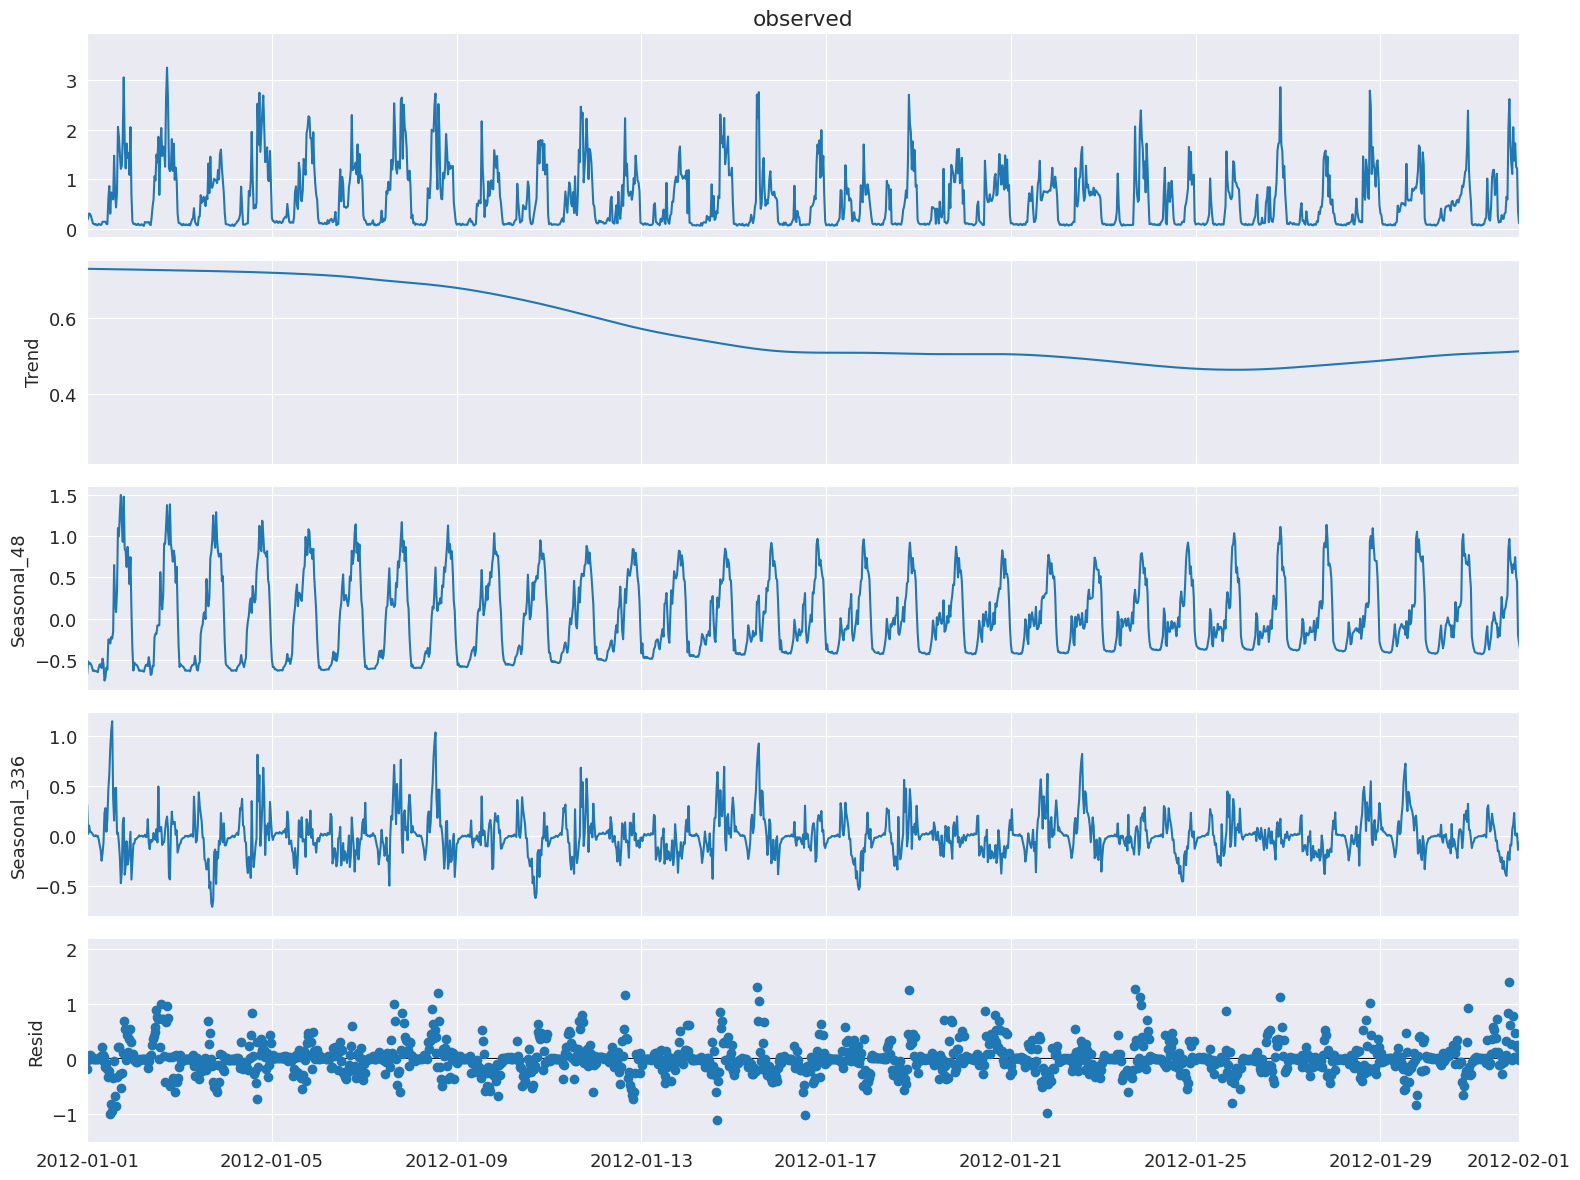

In [42]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Creating a plot
fig = res.plot()

for ax in fig.axes:
    ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-02-01'))

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

In [43]:
fig = plot_autocorrelation(res.resid, vertical=True)
fig.write_image(dst_img/"acf_pacf.png")
fig.show()

In [44]:
# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(ts_df_mstl.energy_consumption_imputed)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.
